# what are the features influencing students successfully finish ND 3

## wonder if features are ND-specific.
  * for example, diff. ND have diff. programming skills requirements
  * ND - goal 

In [1]:
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import random
import re
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
conn_laurel = psycopg2.connect("dbname='analytics' user='analytics' host='analytics.cv90snkxh2gd.us-west-2.rds.amazonaws.com' password='!TgP$Ol9Z&6QhKW0tmn9mOW5rYT2J8'")
conn_hardy = psycopg2.connect("dbname='analytics' user='u_yidong' host='udacity-segment.c2zpsqalam7o.us-west-2.redshift.amazonaws.com' port='5439' password='Lyd580809?!'")

sql_apps = "SELECT distinct a.id as application_id,a.cohort_id,a.applicant_id,a.nd_key,a.application_type\
      ,coalesce(a.applicant_country,'Unknown') as applicant_country\
      ,coalesce(a.applicant_geo,'Unknown') as applicant_geo\
      ,case when b.user_id is not null then 'term completed'\
            when a.first_charge_created_at is not null and a.accepted_at is not null then 'paid'\
            when a.accepted_at is not null then 'accepted'\
            when a.rejected_at is not null then 'rejected'\
            when a.submitted_at is not null then 'submitted'\
       else 'applied' end as application_status\
      ,current_date - a.applicant_created_at::date as user_age\
      ,a.cohort_notify_at::date - a.cohort_open_at::date as cohort_open_to_notify\
      ,a.cohort_close_at::date - a.cohort_open_at::date as cohort_open_to_close\
      ,date_part('month',a.cohort_open_at) as cohort_open_month\
      ,date_part('month',a.application_created_at) as application_month\
      ,a.application_created_at::date - a.cohort_open_at::date as apply_before_start\
      ,a.submitted_at::date - a.application_created_at::date as apply_to_submit\
      ,coalesce(a.accepted_at,a.rejected_at)::date - a.submitted_at::date as submit_to_decision\
      ,a.cohort_notify_at::date - a.submitted_at::date as submit_to_notify\
      ,greatest(coalesce(c.first_charge_attempt::date,a.first_charge_created_at::date) - a.cohort_notify_at::date,0) as notify_to_pay\
      ,coalesce(a.price,0)::int as price\
       FROM admissions.applications as a\
       LEFT JOIN enrollments.term_completions as b ON a.applicant_id = b.user_id and a.nd_key = b.nd_key\
       LEFT JOIN (select distinct account_key,nd_key,cohort_id,min(charge_created_at) as first_charge_attempt from payments.charges\
                  group by account_key,nd_key,cohort_id) as c on a.applicant_id = c.account_key and substring(a.nd_key,0,6) = substring(c.nd_key,0,6) \
            and (case when a.application_type = 'term' then a.cohort_id::int else 0 end) = coalesce(c.cohort_id,0)\
       WHERE accepted_at is not null and first_charge_created_at is not null\
         AND email not like '%@udacity%';"
sql_course = "select application_id,cohort_id,user_id AS applicant_id,nanodegree_key AS nd_key\
       ,count(distinct course_key) as num_courses\
       ,count(distinct case when course_finished = 2 then course_key else null end) as num_course_finished\
       ,count(distinct case when course_finished = 1 then course_key else null end) as num_course_enrolled\
       ,current_date - first_course_started_at::date AS user_study_age\
 from (select distinct b.application_id,b.cohort_id,a.user_id,b.nanodegree_key,course_key,join_time,leave_time\
             ,first_value(join_time) over (partition by a.user_id order by join_time rows between unbounded preceding and unbounded following) as first_course_started_at\
             ,case when a.leave_time::Date <= b.received_at::Date then 2\
                   when a.leave_time is not null then 1 \
              else 0 end as course_finished\
       from analytics_tables.course_enrollments as a\
       inner join backend_admissions.application_received as b on a.user_id = b.user_id\
       where a.join_time <= b.received_at\
      ) group by application_id,cohort_id,user_id,nanodegree_key,current_date - first_course_started_at::date"

df_apps = pd.read_sql(sql_apps,conn_laurel)
df_course = pd.read_sql(sql_course,conn_hardy)

df = pd.merge(df_apps,df_course,on=['application_id','cohort_id','applicant_id','nd_key'],how='inner')

In [3]:
df['application_status'].unique()

array(['paid', 'term completed'], dtype=object)

In [4]:
df.columns

Index(['application_id', 'cohort_id', 'applicant_id', 'nd_key',
       'application_type', 'applicant_country', 'applicant_geo',
       'application_status', 'user_age', 'cohort_open_to_notify',
       'cohort_open_to_close', 'cohort_open_month', 'application_month',
       'apply_before_start', 'apply_to_submit', 'submit_to_decision',
       'submit_to_notify', 'notify_to_pay', 'price', 'num_courses',
       'num_course_finished', 'num_course_enrolled', 'user_study_age'],
      dtype='object')

In [5]:
cols = ['application_id','application_status'
        ,'nd_key','application_type'
        ,'applicant_geo','user_age','cohort_open_to_notify','cohort_open_to_close','cohort_open_month'
        ,'application_month','apply_before_start','apply_to_submit','submit_to_decision'
        ,'submit_to_notify','notify_to_pay','price','num_courses','num_course_finished'
        ,'num_course_enrolled','user_study_age']

In [50]:
df.groupby(['nd_key'])['application_id'].count()

nd_key
nd001-connect            2
nd002-connect            5
nd004-connect-reno       1
nd009-connect            7
nd013                 2333
nd113                    1
nd209                 1040
nd889                  851
Name: application_id, dtype: int64

In [6]:
# questions
sql_questions = "select distinct application_id,cohort_id,applicant_id,nd_key\
                        ,question_id,question_prompt,response,question_prompt||' A:'||response as q_r\
                from admissions.question_responses\
                where application_type != 'scholarship' and response is not null\
                  and question_id in ('question_id','48e7b492-62b4-4d99-b596-80d68f2966ae','cad2565e-8176-44b5-9080-14cfc67ea9b4','fba3666b-db04-46e9-8f3d-2a303f13e0a5','26330483-09a3-444a-b534-e9cd7021ec1c','42b96348-56c4-4e3b-b0f9-8d3911969e48','516737fe-4567-48d2-8645-08d335e21b0c','0c22dbaa-bf1d-4c67-be34-a61014591d6f','2ad03aaa-1b35-4381-9c43-907b1b4eba67','6afe0061-746b-4bd7-807c-393fe5c7599d','779c3b6c-3648-423b-8d3f-8a4f36f23e2a','1346c396-a687-4082-a10e-d3556ac50b4b','1cfe0061-746b-4bd7-807c-393fe5c7599d','ed06fc88-6a59-40a8-b7ea-ece90d83c333','fa332682-b62e-4791-b95f-c528b532a754','e42e1049-e459-4602-ae4b-cb78098dcf89','01f28833-152f-438d-a831-51e33583bde5','7c55f3cc-1c0b-4d95-97f9-cc3409e3145f','a633a338-9726-472a-a0ff-0d8695b30638','f1a93ec7-e2cd-46b6-ba28-2f36b30539a9','6967091c-09c6-4455-9f1e-d0de318bacc5','011ef02c-abea-476d-afdc-d1aa8a456b94','0f617540-5680-480c-aaf3-0663c17c3c7d','1dfe0061-746b-4bd7-807c-393fe5c7599d','20f21bd0-eb3e-4898-ae1f-eb994f9ce823','45781b84-093b-41c7-b5a4-c521f343bf21','47d35057-b1fb-4106-8218-7e551497420e','491b500b-26a2-425b-b142-00773f1d1938','5cf34496-6bc3-4c8d-9c6a-7c037f48669f','70ffc637-2162-484a-b863-3a1a1469f106','7a09e78a-8000-459e-9d79-aa21db135138','823a8248-b7d7-4dbe-a619-2969ca453f1e','8afe0061-746b-4bd7-807c-393fe5c7599d','8ea6732d-0ef9-489d-bf11-20673183a0c2','9481dc6b-c4e9-4207-a30c-65c3ac302bf5','995331ea-092b-4b71-8122-a0c65214c765','9d5c6390-a690-4d6d-8aaa-c60a772b4550','a26ac91f-c263-49f1-8171-9821bc4d2da5','a71ff6e3-1b33-4e11-94f1-5b94d786b5ab','a7b7f95b-1924-4189-840e-b5c407545908','ae155453-72b2-4247-8da5-dced5270f29b','bdc024d8-7712-48ff-b86e-292be1df0d9f','d3b0e6c7-0601-4651-851f-7ef4bea1aa6d','d8f9089c-c3a5-4d77-9c37-ae248e134e42','d9af077d-b729-4971-84b8-f86f390789c1','da04a859-199c-42cf-ab5d-6132bc529161','dc898f2e-1810-4d93-9db0-f381778d45e1','f254514a-26f4-4d29-83af-711c27d4862d','f34c024a-b446-464e-add0-558c9eb8a3c8','fa537969-017a-4816-a317-b5883305c723')"
df_questions = pd.read_sql(sql_questions,conn_laurel)
df_questions.head()

,application_id,cohort_id,applicant_id,nd_key,question_id,question_prompt,response,q_r
0,0001883b-f88d-4662-afea-717fbba580a0,129,4746120864,nd889,2ad03aaa-1b35-4381-9c43-907b1b4eba67,What do you hope to accomplish through this pr...,I am currently writing Machine Learning Code a...,What do you hope to accomplish through this pr...
1,0001883b-f88d-4662-afea-717fbba580a0,129,4746120864,nd889,48e7b492-62b4-4d99-b596-80d68f2966ae,What is the highest level of education you hav...,Master's degree,What is the highest level of education you hav...
2,0001883b-f88d-4662-afea-717fbba580a0,129,4746120864,nd889,516737fe-4567-48d2-8645-08d335e21b0c,What gender do you most identify with?,Male,What gender do you most identify with? A:Male
3,0001883b-f88d-4662-afea-717fbba580a0,129,4746120864,nd889,6967091c-09c6-4455-9f1e-d0de318bacc5,How many years of professional experience do y...,5+ years,How many years of professional experience do y...
4,0001883b-f88d-4662-afea-717fbba580a0,129,4746120864,nd889,779c3b6c-3648-423b-8d3f-8a4f36f23e2a,What is your primary purpose in taking this pr...,Grow skills for my current role,What is your primary purpose in taking this pr...


In [7]:
# merge data first -- inner join to make sure only have data we interested in
df_qr = pd.merge(df,df_questions,on=['application_id','cohort_id','applicant_id','nd_key'],how='inner')
df_qr.shape

(44173, 27)

In [13]:
# categorical
df1 = df
categories = {'education':'48e7b492-62b4-4d99-b596-80d68f2966ae'
             ,'employment':'fba3666b-db04-46e9-8f3d-2a303f13e0a5'
             ,'professional_experience':'6967091c-09c6-4455-9f1e-d0de318bacc5'
             ,'goal':'779c3b6c-3648-423b-8d3f-8a4f36f23e2a'}
for i,qr_id in categories.items():
    d = df_qr.copy()
    d[i] = 0
    d[i] = np.where(d['question_id']==qr_id,d['response'],'0')
    o_i = d.groupby('application_id').agg({i:'max'}).reset_index()
    df1 = pd.merge(df1,o_i,on=['application_id'],how='inner')
    d_i = pd.get_dummies(o_i[i])
    df_i = pd.concat([o_i['application_id'],d_i],axis=1)
    df1 = pd.merge(df1,df_i,on='application_id',how='inner')

In [40]:
# programming languages
data = df1
for i in (['python','java','cplus','probability','statistics','linear algebra','computer science','machine learning']):
    if i == 'cplus':
        j = 'c\+\+' 
    else:
        j = i
    d = df_qr.copy()
    d[i] = 0
    d[i] = np.where(d['response'].str.lower().str.contains(j),1,d[i])
    d[i] = np.where(d['question_prompt'].str.lower().str.contains(j)&d['response'].str.match('.*[1-9].*'),1,d[i])
    o_i = d.groupby('application_id').agg({i:'max'}).reset_index()
    data = pd.merge(data,o_i,on=['application_id'],how='inner')

In [42]:
# sample data and force paid : term_complete = 1 : 1
data_0 = data[data['application_status']=='paid'].reset_index()
data_1 = data[data['application_status']=='term completed'].reset_index()
num = data_1.shape[0]
data_2 = data_0.iloc[random.sample(range(data_0.shape[0]),num),:]
data_s = pd.concat([data_1,data_2],axis=0)
data_s.groupby(['application_status'])['application_id'].count()

application_status
paid              620
term completed    620
Name: application_id, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]), <a list of 19 Text xticklabel objects>)

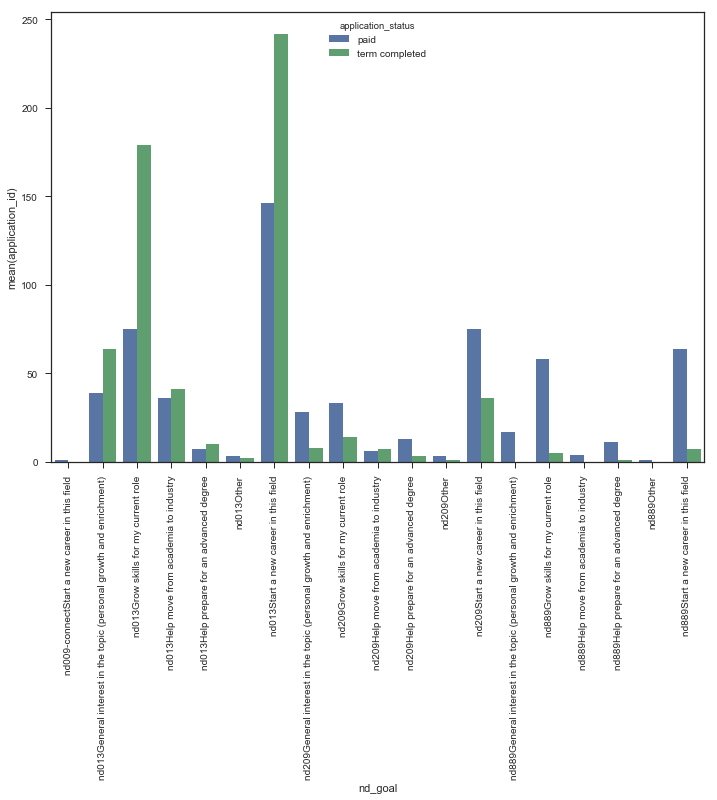

In [29]:
#goal
d_v = data_s.copy()
d_v['nd_goal'] = d_v['nd_key'] + d_v['goal']

sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.barplot(x="nd_goal",y="application_id",hue="application_status"
           ,data=d_v.groupby(['nd_goal','application_status'])['application_id'].count().reset_index())
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

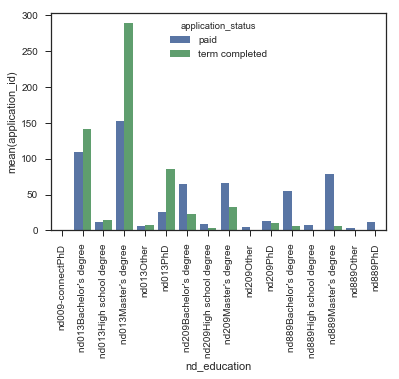

In [30]:
#education
d_v = data_s.copy()
d_v['nd_education'] = d_v['nd_key'] + d_v['education']
sns.barplot(x="nd_education",y="application_id",hue="application_status"
           ,data=d_v.groupby(['nd_education','application_status'])['application_id'].count().reset_index())
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]), <a list of 19 Text xticklabel objects>)

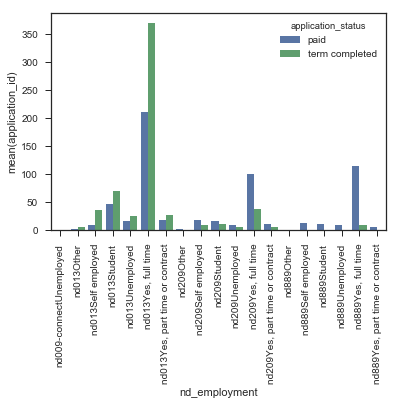

In [31]:
#employment
d_v = data_s.copy()
d_v['nd_employment'] = d_v['nd_key'] + d_v['employment']
sns.barplot(x="nd_employment",y="application_id",hue="application_status"
           ,data=d_v.groupby(['nd_employment','application_status'])['application_id'].count().reset_index())
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

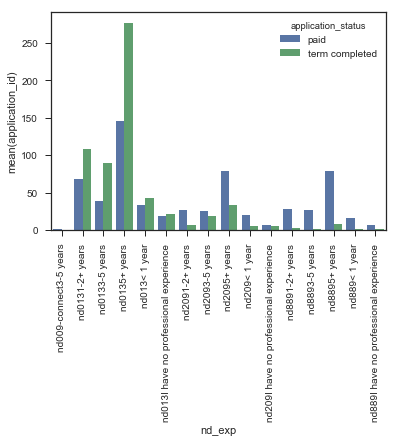

In [32]:
#professional experience
d_v = data_s.copy()
d_v['nd_exp'] = d_v['nd_key'] + d_v['professional_experience']
sns.barplot(x="nd_exp",y="application_id",hue="application_status"
           ,data=d_v.groupby(['nd_exp','application_status'])['application_id'].count().reset_index())
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

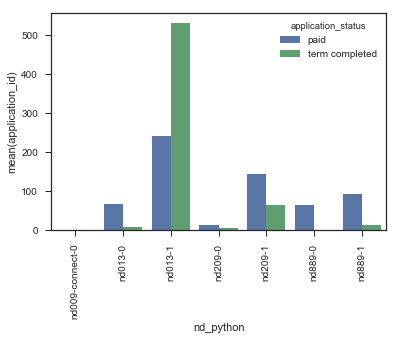

In [37]:
#python
d_v = data_s.copy()
d_v['nd_python'] = d_v['nd_key'] + "-" + d_v['python'].apply(str)
sns.barplot(x="nd_python",y="application_id",hue="application_status"
           ,data=d_v.groupby(['nd_python','application_status'])['application_id'].count().reset_index())
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

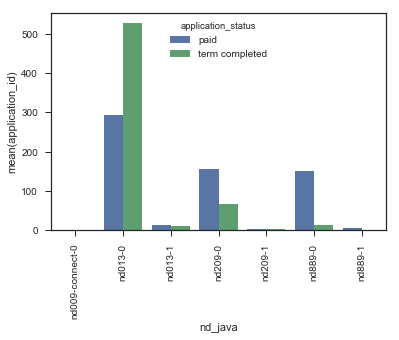

In [38]:
#java
d_v = data_s.copy()
d_v['nd_java'] = d_v['nd_key'] + "-" + d_v['java'].apply(str)
sns.barplot(x="nd_java",y="application_id",hue="application_status"
           ,data=d_v.groupby(['nd_java','application_status'])['application_id'].count().reset_index())
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

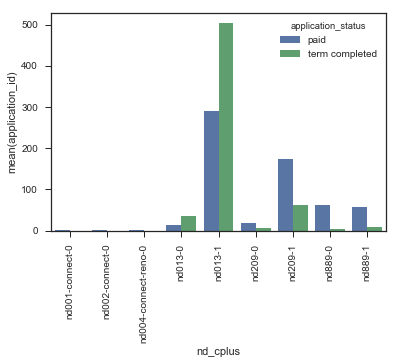

In [43]:
#cplus
d_v = data_s.copy()
d_v['nd_cplus'] = d_v['nd_key'] + "-" + d_v['cplus'].apply(str)
sns.barplot(x="nd_cplus",y="application_id",hue="application_status"
           ,data=d_v.groupby(['nd_cplus','application_status'])['application_id'].count().reset_index())
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

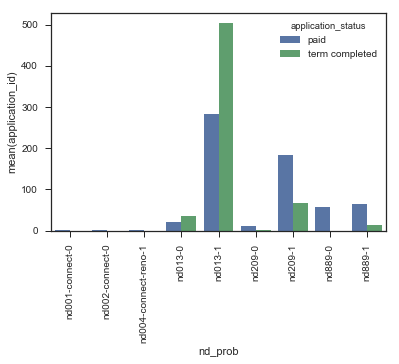

In [44]:
#probability
d_v = data_s.copy()
d_v['nd_prob'] = d_v['nd_key'] + "-" + d_v['probability'].apply(str)
sns.barplot(x="nd_prob",y="application_id",hue="application_status"
           ,data=d_v.groupby(['nd_prob','application_status'])['application_id'].count().reset_index())
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

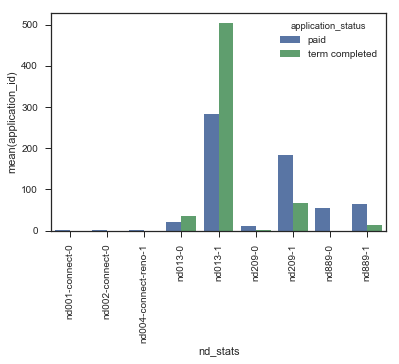

In [45]:
#statistics
d_v = data_s.copy()
d_v['nd_stats'] = d_v['nd_key'] + "-" + d_v['statistics'].apply(str)
sns.barplot(x="nd_stats",y="application_id",hue="application_status"
           ,data=d_v.groupby(['nd_stats','application_status'])['application_id'].count().reset_index())
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

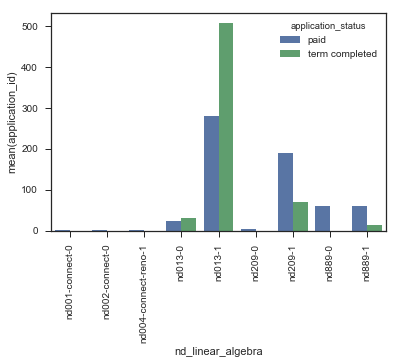

In [46]:
#linear algebra
d_v = data_s.copy()
d_v['nd_linear_algebra'] = d_v['nd_key'] + "-" + d_v['linear algebra'].apply(str)
sns.barplot(x="nd_linear_algebra",y="application_id",hue="application_status"
           ,data=d_v.groupby(['nd_linear_algebra','application_status'])['application_id'].count().reset_index())
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

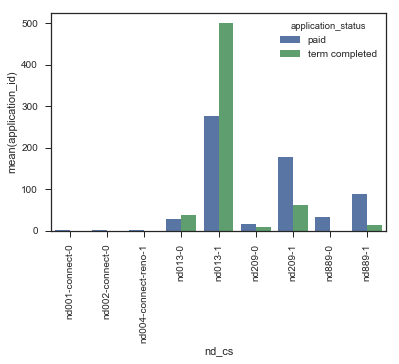

In [47]:
#computer science
d_v = data_s.copy()
d_v['nd_cs'] = d_v['nd_key'] + "-" + d_v['computer science'].apply(str)
sns.barplot(x="nd_cs",y="application_id",hue="application_status"
           ,data=d_v.groupby(['nd_cs','application_status'])['application_id'].count().reset_index())
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

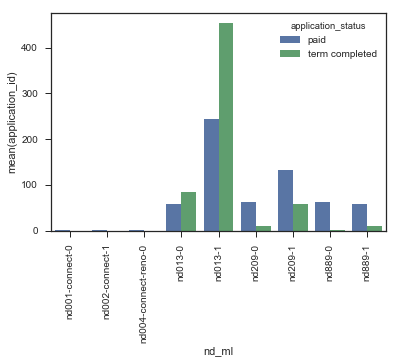

In [48]:
#machine learning
d_v = data_s.copy()
d_v['nd_ml'] = d_v['nd_key'] + "-" + d_v['machine learning'].apply(str)
sns.barplot(x="nd_ml",y="application_id",hue="application_status"
           ,data=d_v.groupby(['nd_ml','application_status'])['application_id'].count().reset_index())
plt.xticks(rotation=90)

In [ ]:
# LR in nd_key only

In [52]:
data_s['application_status'] = data_s['application_status'].map({'paid':0,'term completed':1})

In [54]:
nd_key = pd.get_dummies(data_s['nd_key'])
d_nd = pd.concat([nd_key,data_s['application_status']],axis = 1)

In [55]:
logit = sm.Logit(d_nd['application_status'], nd_key)
result = logit.fit()
print(result.summary())

         Current function value: 0.599673
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:     application_status   No. Observations:                 1240
Model:                          Logit   Df Residuals:                     1234
Method:                           MLE   Df Model:                            5
Date:                Tue, 31 Oct 2017   Pseudo R-squ.:                  0.1349
Time:                        17:54:02   Log-Likelihood:                -743.59
converged:                      False   LL-Null:                       -859.50
                                        LLR p-value:                 4.364e-48
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
nd001-connect        -17.5796   6566.897     -0.003      0.998   -1.29e+04    1.29e+04
nd002-connect        -17.5796   6566.897 

/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


# based on LR above, Nd013, nd209, nd889 behaved very diff. to grad. rate